#Query-> Query planning and decomposition -> Chain of thoughts -> ReAct-> Iterative Retrieval -> Answer synthesis -> self reflection -> end/ iterative retival.

In [ ]:
pip install langchain_openai langgraph langchain_community Arxiv wikipedia langchain_tavily

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader,TextLoader, ArxivLoader
from langchain.chat_models import init_chat_model
from langchain_openai import OpenAIEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field
from typing import Literal,List
from langchain_classic.schema import Document
from langchain_core.messages import HumanMessage, AIMessage,AnyMessage
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from typing import Annotated, Sequence
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import create_react_agent
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
#from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_tavily import TavilySearch
from langchain_community.utilities import SerpAPIWrapper
from langchain_community.utilities.github import GitHubAPIWrapper

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "your api key"
os.environ["TAVILY_API_KEY"] = "your api key"
os.environ["GITHUB_TOKEN"] = "your api key"

In [ ]:
import asyncio
import nest_asyncio
nest_asyncio.apply()

In [ ]:
class RagState(BaseModel):
    question: str
    plan: str = ""
    retrieved_docs: List[Document] = []
    sub_questions: List[str] = []
    refined_question: str = ""
    answer: str = ""
    reflection: str = ""
    score: float = 0.0
    attempts: int = 0

In [ ]:
from langchain_core.messages import HumanMessage, ToolMessage,BaseMessage
from langchain_core.runnables import RunnableConfig

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import Tool

In [ ]:
arxiv_wrap = ArxivAPIWrapper(top_k_results=3, doc_content_chars_max=4000)
Arxiv = ArxivQueryRun(api_wrapper=arxiv_wrap)

wiki_wrap = WikipediaAPIWrapper(top_k_results=3, doc_content_chars_max=4000)
Wiki = WikipediaQueryRun(api_wrapper=wiki_wrap)

Tavily = TavilySearch(max_results=3)

# Define tools
tools = [Arxiv, Wiki, Tavily]

# Initialize LLM and bind tools (the ReAct brain)
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_bind = llm.bind_tools(tools)

# Defining the AgentState to track conversation
class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], add_messages]
  number_of_steps: int

#Define tool lookup
tools_by_name = {tool.name: tool for tool in tools}

# 🔁 Tool caller node
async def call_tool(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_name = tool_call["name"]
        args = tool_call["args"]
        print(f" Using tool: {tool_name} | Query: {args}")
        result = tools_by_name[tool_name].invoke(args)
        outputs.append(
            ToolMessage(
                content=str(result),
                name=tool_name,
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

# Model reasoning node
async def call_model(state: AgentState, config: RunnableConfig):
    response = await llm_bind.ainvoke(state["messages"], config)
    return {"messages": [response]}

# Conditional edge: decide whether to continue or stop
async def should_continue(state: AgentState):
    last = state["messages"][-1]
    if not getattr(last, "tool_calls", None):
        return "end"
    return "continue"

# Build the LangGraph ReAct loop
workflow = StateGraph(AgentState)
workflow.add_node("llm", call_model)
workflow.add_node("tools", call_tool)
workflow.set_entry_point("llm")
workflow.add_conditional_edges("llm", should_continue, {"continue": "tools", "end": END})
workflow.add_edge("tools", "llm")
graph = workflow.compile()

# Run a test query
#query = "Summarize the latest research on multimodal RAG systems and their benchmarks."
#state = {"messages": [HumanMessage(content=query)]}
#result = graph.invoke(state)

#print("\n\nFinal Response:\n", result["messages"][-1].content)

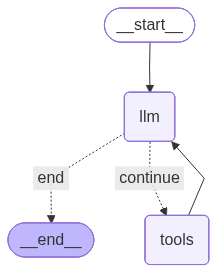

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
llm_fast = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [41]:
async def react_retriever_async(query: str) -> str:
    """AsyncReAct retriever."""
    result = await graph.ainvoke({"messages": [HumanMessage(content=query)]})
    return result["messages"][-1].content

In [42]:
async def QueryPlanning(state: RagState) -> RagState:
    prompt = f"""Break the following question into 2–3 focused sub-questions:
    Question: {state.question}
    Sub-questions:"""
    plan_result = await llm_fast.ainvoke([HumanMessage(content=prompt)])
    subs = [ln.strip("- ").strip() for ln in plan_result.content.split("\n") if ln.strip()]
    return state.model_copy(update={"sub_questions": subs})

In [43]:
async def retrieve_for_each(state: RagState) -> RagState:
    """
    Run ReAct retrieval concurrently for all sub-questions.
    """
    print("\n Automatic Retrieval Started")

    # Create async tasks
    tasks = [react_retriever_async(sub) for sub in state.sub_questions]

    # Run them all in parallel
    results = await asyncio.gather(*tasks, return_exceptions=True)

    all_docs = []
    for i, res in enumerate(results, start=1):
        sub = state.sub_questions[i - 1]
        if isinstance(res, Exception):
            print(f" Retrieval failed for sub-question {i}: {res}")
            continue
        print(f"✅ Sub-question {i}: {sub[:60]}... -> retrieved {len(res)} chars")
        all_docs.append(Document(page_content=res))

    return state.model_copy(update={"retrieved_docs": all_docs})


In [44]:
async def synthesize_answer(state: RagState) -> RagState:
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    #prompt = f"""
    #You have retrieved relevant context from multiple sources. Now synthesize a complete and coherent answer.
    prompt = f"""
    You are an expert AI/Software engineer.
    Your task is to generate a practical, executable solution (preferably in Python)
    based on the retrieved context and user question.

    Rules:
    - If the question involves data, finance, AI, or analytics → write complete Python code.
    - If it's web-related → write React, Streamlit, or HTML code.
    - Always include step-by-step inline comments in the code.
    - Avoid vague explanations — prefer runnable examples.
    - Include sample inputs and outputs if applicable.
    - At the end, add a short explanation (3-5 lines max) of what the code does.
    Question: {state.question}
    Context: {context}

    Now write the executable solution:
    """
    answer = (await llm.ainvoke([HumanMessage(content=prompt)]))
    return state.model_copy(update={"answer": answer.content.strip()})

In [45]:
async def self_reflect(state: RagState) -> RagState:
    prompt = f"""Review the answer below and see if it fully addresses the question.
    - Is it correct and complete?
    - What can be improved?
    Finally, on a new line, write:
    Confidence Score: <number between 0 and 100>

    Question: {state.question}
    Answer: {state.answer}
    """
    resp = await llm_fast.ainvoke([HumanMessage(content=prompt)])
    reflection = resp.content.strip()

    # Extract score safely
    import re
    matches = re.findall(r"\b\d{1,3}\b", reflection)
    score = max([float(n) for n in matches if 0 <= float(n) <= 100], default=0.0)

    return state.model_copy(update={
        "reflection": reflection,
        "score": score,
        "attempts": state.attempts + 1
    })


In [46]:
# Create a new graph for the RAG workflow
rag_graph = StateGraph(RagState)

rag_graph.add_node("Plan", QueryPlanning)
rag_graph.add_node("Retrieve", retrieve_for_each)
rag_graph.add_node("Synthesize", synthesize_answer)
rag_graph.add_node("Reflect", self_reflect)


rag_graph.set_entry_point("Plan")


rag_graph.add_edge("Plan", "Retrieve")
rag_graph.add_edge("Retrieve", "Synthesize")
rag_graph.add_edge("Synthesize", "Reflect")


def reflection_decision(state: RagState):
    """
    Decide where to go next based on the reflection score.
    - If score < 80 → Retry retrieval.
    - Else → End the pipeline.
    """
    if state.score < 80 and state.attempts < 3:
        print(f"\n  Reflection score {state.score} < 80 → retrying retrieval...\n")
        return "retry"
    return "end"

# Add conditional transition logic
rag_graph.add_conditional_edges(
    "Reflect",
    reflection_decision,
    {"retry": "Retrieve", "end": END},
)

rag_pipeline = rag_graph.compile()


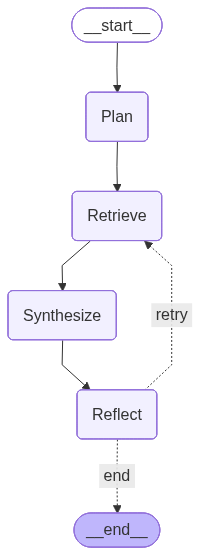

In [47]:
display(Image(rag_pipeline.get_graph().draw_mermaid_png()))

In [48]:
async def main():
  query = "Create a Python program that generates an AI-powered investment portfolio based on risk profile."
  result = await rag_pipeline.ainvoke({"question": query})
  print("\n🧠 Final Answer:\n", result["answer"])
  #print("\n💬 Reflection:\n", result["reflection"])
  #print("\n✅ Confidence Score:", result["score"])

await main()


 Automatic Retrieval Started
 Using tool: arxiv | Query: {'query': 'portfolio generation data sources AI techniques'}
✅ Sub-question 1: 1. What factors should be considered when determining an ind... -> retrieved 2134 chars
✅ Sub-question 2: 2. How can we implement an algorithm in Python to generate a... -> retrieved 3733 chars
 Retrieval failed for sub-question 3: Page request resulted in HTTP 429 (https://export.arxiv.org/api/query?search_query=portfolio+generation+data+sources+AI+techniques&id_list=&sortBy=relevance&sortOrder=descending&start=0&max_results=100)

🧠 Final Answer:
 Here's a complete Python program that generates an AI-powered investment portfolio based on a specified risk profile. The program defines different risk profiles, simulates historical returns for various asset classes, calculates expected returns and risks, and optimizes the portfolio allocation.

```python
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Step 1: Define risk pro